### 提升方法 AdaBoost

> 理论 《统计学习方法》第8章 提升方法
>
> 代码 numpy version && torch version
>
> Python3.7
>
> created 2023/02/14
>
> author lyz
>
> email 2281250383@qq.com

提升Boosting方法在分类问题中，通过改变训练样本的权重，学习多个分类起，并将这些分类器进行线形组合，提高分类器的性能

对于分类问题，给定训练集，找一个弱分类器会简单的多。提升方法就是从弱学习算法出发，反复学习，得到一系列的弱分类器（基本分类器），然后组合这些弱分类器，构成一个强分类器。

大多数的Boosting都是通过改变训练数据的概率分布（权值分配），然后针对不同的训练数据分布调用弱分类器学习一系列的弱分类器

#### AdaBoost基本思想

Adaboost方法是通过改变训练样本权重来学习多个弱分类器并线性组合形成强分类器的提升算法

提高被前一轮弱分类器误分类的样本权重，降低正确分类的样本权重 ---> 新一轮训练时候弱分类器会更加关注前一轮被误分类的样本

得到的一系列弱分类器，AdaBoost使用加权多数表决的方法 ---> 加大分类误差率小的弱分类器权值，使得其在表决中起到较大作用

#### AdaBoost算法描述

现嘉定一个二分类问题

输入： 训练数据集T，弱学习算法
输出： 最终分类器$G(x)$
1. 初始化训练数据的权值分布$D_1$。第一次相同权值$w_{1i} = 1\over N$
2. 一轮训练
    1. 对$D_m$的训练数据集学习，得到基本分类器$G_M$
    2. 计算$G_m(x)$在训练数据集上的分类误差率
    3. 计算$G_m(x)$的系数
    4. 更新训练数据集的权值分布
3. 构建基本分类器的线形组合，得到最终分类器



In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
import torch
from torch import nn
import torch.utils.data as data
import random

In [2]:
x_train = np.array([0,1,2,3,4,5,6,7,8,9])
y_train = np.array([1,1,1,-1,-1,-1,1,1,1,-1])
print(x_train.shape)
print(y_train.shape)

(10,)
(10,)


(200, 2)
(200,)


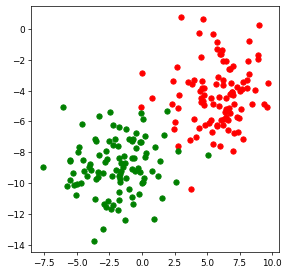

In [3]:
x,y = make_blobs(n_samples=200,
                 n_features=2,
                 centers=2,
                 cluster_std=2,
                 random_state=40)
y_ = y.copy()
# 将标签转换为1/-1
y_[y_==0]=-1
y_.astype(float)

def draw_fig(x,y,w,b):
    plt.figure(dpi=64,figsize=(5,5))

    # 正负实例的散点图，这儿使用了一个Bool索引，切片混合索引
    plt.scatter(x[y==1][:,0],x[y==1][:,1],color='r')
    plt.scatter(x[y==-1][:,0],x[y==-1][:,1],color='g')

    # 画分离超平面
    if w and b:
        x1 = np.arange(-1, 4, 0.1)
        x2 = (w[0] * x1 + b) / (-w[1])
        plt.plot(x1,x2)

    plt.show()

print(x.shape)
print(y.shape)
draw_fig(x,y_,None,None)

In [4]:
# 划分训练集和测试集
x_train,x_test,y_train,y_test = train_test_split(x,y_,test_size=0.2,random_state=1)

#### 决策树桩 decision stump

单层决策树，通过给定阈值进行分类

决策树桩根据一个属性的单个判断来确定最终的分类结果

做的事：

1. 从所有的属性中，选择哪一个属性作为决策树桩（弱学习器）
2. 设置该决策树桩的阈值
3. 大于/小于阈值的时候预测为正

In [5]:
# 单层决策树（decision stump，也称决策树桩）
class decision_stump(object):
    def __init__(self):
         # 基于划分阈值决定样本分类为1还是-1
         self.label=1
         # 特征索引
         self.feature_index=None
         # 特征划分阈值
         self.threshold=None
         # 指示分类准确率
         self.alpha=None

In [6]:
# 定义Adaboost算法
class Adaboost(object):
    # 弱分类器个数
    def __init__(self,n_estimators=10):
        self.estimators = None
        self.n_estimators = n_estimators

    def fit(self,x,y):
        m,n = x.shape
        # 1.初始化训练集权值分布为均匀分布 1/N
        w = np.full(m,(1/m))
        # 初始化基础分类器列表
        self.estimators = []
        # 2. for m in （1，2，3，...,m)
        for ixe in range(self.n_estimators):
            # 2.1 训练一个弱分类器：决策树桩
            estimator = decision_stump()
            min_error = float('inf')

            """
                训练弱分类器
            """
            # 遍历数据集特征，根据最小分类误差率选择最优划分特征
            # 遍历n个特征
            for i in range(n):
                # 获取特征值
                values = np.expand_dims(x[:,i],axis=1)
                # 特征值去重
                unique_values = np.unique(values)
                # 尝试将每个特征值作为分类阈值
                for threshold in unique_values:
                    p = 1
                    # 先初始化所有的预测值为1
                    pred = np.ones(np.shape(y))
                    # 小于分类阈值的预测值为-1
                    pred[x[:,i]<threshold]= -1
                    # 2.2 计算误差率
                    error = sum(w[y!=pred])
                    # 若分类误差>0.5则进行正负预测值翻转
                    if error>0.5:
                        error = 1 - error
                        p = -1

                    # 得到最小误差则保存相关参数配置
                    if error<min_error:
                        estimator.label = p
                        estimator.threshold = threshold
                        estimator.feature_index = i
                        min_error = error

            # 2.3 计算基础分类器的权重
            estimator.alpha = 0.5 * np.log((1-min_error)/(min_error+1e-9))
            # 初始化所有预测值为1
            preds = np.ones(np.shape(y))
            # 获取所有小于阈值的负类索引
            negative_idx = (estimator.label*x[:,estimator.feature_index] < estimator.label * estimator.threshold)
            # 负类设置为 -1
            preds[negative_idx]=-1
            # 更新样本权重
            w *= np.exp(-estimator.alpha*y*preds)
            w /= np.sum(w)
            # 保存弱分类器
            self.estimators.append(estimator)

            print('decision stump {}, param: label {}; threshold {:.2f}; feature_ix {}; alpha {:.2f}'.format(ixe,estimator.label,estimator.threshold,estimator.feature_index,estimator.alpha))

    def predict(self,x):
        m = len(x)
        y_pred = np.zeros((m,1))
        for estimator in self.estimators:
            predictions = np.ones(np.shape(y_pred))
            negative_idx = (estimator.label * x[:,estimator.feature_index] < estimator.label * estimator.threshold)
            predictions[negative_idx]=-1
            #  对每个弱分类器的预测结果进行加权
            y_pred += estimator.alpha*predictions
        # 返回最终的预测结果
        y_pred = np.sign(y_pred).flatten()
        return y_pred

In [7]:
clf = Adaboost(n_estimators=5)
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print('accuracy:{}'.format(acc))

decision stump 0, param: label 1; threshold 2.32; feature_ix 0; alpha 1.62
decision stump 1, param: label 1; threshold -7.02; feature_ix 1; alpha 1.52
decision stump 2, param: label 1; threshold 2.77; feature_ix 0; alpha 0.75
decision stump 3, param: label 1; threshold -5.04; feature_ix 1; alpha 0.82
decision stump 4, param: label 1; threshold -0.05; feature_ix 0; alpha 0.93
accuracy:1.0
